<a href="https://colab.research.google.com/github/MarkusFranke/RNA-Half-life-for-tissues/blob/main/models-for-general-half-life/Inception_RNN_v24_default_Layernorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from Bio import SeqIO #for parsing Fasta Files
import pandas as pd
from scipy.stats import zscore
from kipoiseq.transforms.functional import one_hot, fixed_len
import numpy as np
import math

from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as k
from keras.callbacks import EarlyStopping, History
from keras.models import Model
import tensorflow_addons as tfa
import tensorflow as tf
import keras.layers as kl
import keras
import numpy as np
import os
import subprocess
import gc

Since we can't run this in google colab due to RAM limitations, I'm importing the data from disk. All the data should be available on google drive though, under the same filenames, either to be downloaded and run with a path to where the user saved them, or to be directly accessible by mounting the google drive (and setting a shortcut to our google drive data path in google drive)


In [ ]:
hl = pd.read_excel(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\kelley_et_al_corrected_hl.xlsx', skiprows=[0, 1])
hl['zscore'] = zscore(hl['half-life (PC1)'])
halflife = hl[["Ensembl Gene Id", "zscore"]]
hl

,Ensembl Gene Id,Gene name,half-life (PC1),Bazzini_ActD_HEK293_1,Bazzini_ActD_HeLa_1,Bazzini_ActD_RPE_1,Bazzini_4sU_K562_1,Akimitsu_BrU_HeLa_1,Rinn_ActD_K562_1,Rinn_ActD_K562_2,...,Gejman_4sU_GM12812_1,Gejman_4sU_GM12814_1,Gejman_4sU_GM12815_1,Simon_4sU_K562_1,Simon_4sU_K562_2,Rissland_4sU_HEK293_1,Rissland_4sU_HEK293_2,Rissland_4sU_HEK293_3,Rissland_4sU_HEK293_4,zscore
0,ENSG00000000003,TSPAN6,8.660955,0.763166,0.258448,0.106486,1.019072,2.022504,1.744745,1.783356,...,1.037361,0.969166,1.209562,2.080643,2.095154,0.674058,1.120375,1.456258,1.791769,1.807620
1,ENSG00000000419,DPM1,2.241221,0.529938,0.222678,-0.040666,-0.284952,0.145097,0.866919,0.832768,...,-0.212424,-0.747989,0.371214,0.772595,0.712843,-0.350914,-0.879247,-0.825603,0.109861,0.467763
2,ENSG00000000457,SCYL3,-6.929173,-0.798471,-0.894854,-1.039150,-1.444532,-1.287191,-1.006317,-1.062201,...,-1.155096,-1.421651,-1.568912,-1.308978,-1.311572,-0.387172,-1.229226,-1.122749,-0.570002,-1.446182
3,ENSG00000000460,C1orf112,0.440909,0.461228,0.195794,-0.739672,-0.123925,0.162538,-0.023056,-0.008479,...,1.365208,1.017193,-0.239569,0.373929,0.380154,-0.063720,-0.450610,-0.805719,0.453957,0.092022
4,ENSG00000000938,FGR,-0.943680,0.164310,0.112064,0.095773,0.045345,0.024136,-0.209157,-0.223700,...,0.722198,1.024313,1.484018,-0.375671,-0.384504,0.232924,0.347933,0.266619,0.063565,-0.196955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13916,ENSG00000284770,TBCE,2.218664,0.100281,-0.187624,-0.143422,0.201024,0.933352,0.465403,0.451758,...,1.082013,0.917651,0.897480,0.866792,0.868080,-0.104068,-0.169414,-0.404886,-0.165188,0.463055
13917,ENSG00000285077,ARHGAP11B,-3.262964,-0.733980,-0.934478,-0.952570,-0.461339,-0.940048,0.225157,0.161858,...,0.256969,0.033071,-0.249782,-1.116405,-1.078302,-1.495412,-1.006317,-1.240272,-1.440629,-0.681011
13918,ENSG00000288596,C8orf44,2.118850,-0.485957,-0.320560,-0.332189,0.582473,-0.614775,0.305297,0.336730,...,1.023526,-0.155662,-0.950892,-0.175193,-0.166760,2.505294,1.068162,1.307039,1.563308,0.442223
13919,ENSG00000288701,PRRC2B,0.133147,0.133770,0.214899,0.144491,0.090991,0.131956,-0.040831,-0.035576,...,-0.091563,-0.021327,-0.017414,0.088581,0.107441,0.345123,-0.188176,-0.119128,0.001050,0.027789


In [ ]:
with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.3pUTRs.fa') as fasta_file:  # Will close handle cleanly
    UTR3_identifiers = []
    UTR3_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        UTR3_identifiers.append(seq_record.id)
        UTR3_seqs.append(seq_record.seq)

with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.5pUTRs.fa') as fasta_file:  # Will close handle cleanly
    UTR5_identifiers = []
    UTR5_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        UTR5_identifiers.append(seq_record.id)
        UTR5_seqs.append(seq_record.seq)

with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.ORFs.fa') as fasta_file:  # Will close handle cleanly
    ORF_identifiers = []
    ORF_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        ORF_identifiers.append(seq_record.id)
        ORF_seqs.append(seq_record.seq)

print(UTR3_seqs[0])
print(UTR5_seqs[0])
print(ORF_seqs[0])
print(UTR3_identifiers[0])
print(UTR5_identifiers[0])
print(ORF_identifiers[0])
print(len(UTR3_seqs))
print(len(UTR5_seqs))
print(len(ORF_seqs))

AATATTATGTATGCAGCAATATTTGAGTAACAAGAAGCAAATATCCAAGTTCCAAAATTATAAAAGAAATTCTTATCCAAATAGTAATGTTCTAATTGATCATATAAGAAAGCAAAGCATAGACATTAGAATTATAAGTCAGCAGTGGTCTGTTCAAGAACAATCAACATTTTTAGAAAATAGTAGGACAAAATTAGGAAATAATTATCACCAAGAGGATCTAGTTCATGACTTTCTATTATCTCAATTAGATTGCTCAATCATCAGCCTTCCTATACTAAACTCTGATTCAGGACCAAGAAAGGCATAGTCTGACTCTGGAAATGCGCTGTTGGAAGCCAAATAACATCAATACTCTTGTTCTATAATTGAATATCAAATAAGACAAATTACCATTAATTTAATGACTGTGGAGTTAATTGTATACCAGCATTTCAGCAAATCATCATCAATAGTATTACATTAGCAATTTATGCAATTAAAAGGGCTTTGTAAAACTTTGAATAGATTTTATTGTCATTAGTAGCTGTTGGAACTTCATTATTATATAATGTTTTTGCAAACTTTAACTTTTTTCTAAATTGTTAAATAAAAGAATAACTATCCTTAATCTAAATAATTTTGGTAGCAAATCCTATAAGGTATTAAACATTTTAAGGTATATTATTACATTGCTATTTTACTGTTTCTCATTAACCCAAACAGTTTAAAGGCAGAATTCCACTTAGAAACAAGTTGCATTTTGAAAGTTTATTTGTAATCCATTTGTTTGGAATTCAGAAATGTATTTCACATAAAAATAATCTTGGAAGTAATAAATTCCAAAATTAACTAACAAAA
AGATGAGATTTCATCATGTTGGCCAGCCTGGTCTCAAACTCCTGACCTCAAGTGACCCGCCTGCCTCAGCCTCCCAAAGTGCTGGGATTACAGGAATTTAGTGATTGACA
ATGGCAGAAAAAATCCTAGAGAAGTTGGATGTCCTTGATAAGCAAGCA

In [ ]:
exons = pd.read_csv(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Kelley_et_al_exon_junctions.txt', delimiter = "\t")
exons

,GeneID,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000000003,112,"199,388,463,562,697,781"
1,ENSG00000000457,222,"387,573,687,744,847,959,1037,1177,1362,1534,16..."
2,ENSG00000000460,700,"766,871,1012,1178,1263,1402,1483,1548,1697,182..."
3,ENSG00000000938,289,"515,618,717,821,971,1127,1307,1384,1538,1670"
4,ENSG00000000971,240,"298,484,590,667,859,1030,1204,1399,1576,1759,1..."
...,...,...,...
13225,ENSG00000278615,48,"87,212,310"
13226,ENSG00000278619,239,"781,875,1008,1128"
13227,ENSG00000278845,161,"227,405,523,622,671,821,995"
13228,ENSG00000280789,574,"1056,1139"


In [ ]:
chromosomes = pd.read_csv(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Kelley_et_al_chromosomes.txt', delimiter = "\t")
chromosomes

,GeneID,Chromosome
0,ENSG00000186092,1
1,ENSG00000279928,1
2,ENSG00000279457,1
3,ENSG00000278566,1
4,ENSG00000273547,1
...,...,...
20290,ENSG00000277856,KI270726.1
20291,ENSG00000275063,KI270726.1
20292,ENSG00000271254,KI270711.1
20293,ENSG00000277475,KI270713.1


In [ ]:
chromosomes['Chromosome'].value_counts()

1             2053
19            1458
11            1316
2             1298
17            1185
3             1070
6             1045
12            1033
7              980
5              868
16             865
X              824
14             824
9              772
4              747
10             730
8              670
15             609
20             541
22             489
13             320
18             269
21             233
Y               54
MT              13
KI270728.1       6
KI270727.1       4
KI270734.1       3
GL000194.1       2
GL000195.1       2
KI270726.1       2
KI270713.1       2
GL000009.2       1
GL000205.2       1
GL000219.1       1
GL000213.1       1
GL000218.1       1
KI270731.1       1
KI270721.1       1
KI270711.1       1
Name: Chromosome, dtype: int64

In [ ]:
rbp_k = np.load(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\RBP_k.npy')
rbp_k.shape

(13230, 59)

So not only do we have much more chromosomes, we the data comes from Pedro (df), Saluki (the sequences), from Pauline (chromosomes, exon junctions, via Saluki-chosen transcript), and from Yasmine (RBPs using Deepripe).
Thus we should take good care that we merge the tables correctly.

In [ ]:
d = {'geneID': UTR5_identifiers, 'UTR5_seqs': UTR5_seqs}
UTR5 = pd.DataFrame(data=d)
d = {'geneID': ORF_identifiers, 'ORF_seqs': ORF_seqs}
ORF = pd.DataFrame(data=d)
d = {'geneID': UTR3_identifiers, 'UTR3_seqs': UTR3_seqs}
UTR3 = pd.DataFrame(data=d)

#merge every data frame to sequences
halflife = hl[["Ensembl Gene Id", "zscore"]] # half-life
seqs = pd.merge(pd.merge(UTR5, ORF, on ='geneID'), UTR3, on = 'geneID') # Sequence
sequences = pd.merge(halflife, seqs, right_on = 'geneID', left_on = 'Ensembl Gene Id') # half-life + Sequence
sequences = sequences.drop(columns=["geneID"])
sequences = sequences.rename(columns={"Ensembl Gene Id": "geneID"})
sequences = pd.merge(sequences, chromosomes, left_on='geneID', right_on='GeneID') # halflife + Sequence + chromosomes
sequences = sequences.drop(columns=["GeneID"])
sequences = pd.merge(sequences, exons, left_on='geneID', right_on='GeneID')# halflife + Sequence + chromosomes + exons
sequences = sequences.drop(columns=["GeneID"])

#transform seqs into strings:
sequences["UTR5_seqs"] = sequences["UTR5_seqs"].apply(str)
sequences["UTR3_seqs"] = sequences["UTR3_seqs"].apply(str)
sequences["ORF_seqs"] = sequences["ORF_seqs"].apply(str)

rubbish = [d, UTR3, ORF, UTR5, UTR5_seqs, UTR3_seqs, ORF_seqs, UTR3_identifiers, UTR5_identifiers, ORF_identifiers, hl, halflife]
del rubbish

sequences.head()

,geneID,zscore,UTR5_seqs,ORF_seqs,UTR3_seqs,Chromosome,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000000003,1.807620,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...,ATGGCGTCCCCGTCTCGGAGACTGCAGACTAAACCAGTCATTACTT...,CCCAATGTATCTGTGGGCCTATTCCTCTCTACCTTTAAGGACATTT...,X,112,"199,388,463,562,697,781"
1,ENSG00000000457,-1.446182,TGTCCCGTTTCCGGACCCGTCTCTATGGTGTAGGAGAAACCCGGCC...,ATGGGATCAGAGAACAGTGCTTTAAAGAGCTATACACTGAGAGAAC...,CAATAGATGTGAGTTAAACTTTAGGAAAAAGGATTCCCTTTTTTTA...,1,222,"387,573,687,744,847,959,1037,1177,1362,1534,16..."
2,ENSG00000000460,0.092022,GGCTTTGGCCCTGGAAAGCCTCGCGGACGTGTTCTGACCCAAGGTT...,ATGTTTTTACCTCATATGAACCACCTGACATTGGAACAGACTTTCT...,AACTTATCACTAGGCAGAACTGGGTTTGATGCTTTGTCAACTGAAA...,1,700,"766,871,1012,1178,1263,1402,1483,1548,1697,182..."
3,ENSG00000000938,-0.196955,GGCTTGGGGCTAGGGCGTGACTGTCTCCCTGCCACCATCACCGCCC...,ATGGGCTGTGTGTTCTGCAAGAAATTGGAGCCGGTGGCCACGGCCA...,CCTGTCCGGGCATCAACCCTCTCTGGCGGTGGCCACCAGTCCTTGC...,1,289,"515,618,717,821,971,1127,1307,1384,1538,1670"
4,ENSG00000000971,1.611324,ACAGCATTAACATTTAGTGGGAGTGCAGTGAGAATTGGGTTTAACT...,ATGAGACTTCTAGCAAAGATTATTTGCCTTATGTTATGGGCTATTT...,AATCAATCATAAAGTGCACACCTTTATTCAGAACTTTAGTATTAAA...,1,240,"298,484,590,667,859,1030,1204,1399,1576,1759,1..."


In [ ]:
max_len = 10000 #this is slightly longer than the 95% quantile, but lower than Saluki's implementation

seqs = sequences['UTR5_seqs'] + sequences['ORF_seqs'] + sequences['UTR3_seqs']
def pad_sequence(seqs, max_len, anchor='start', value='N'):
  padded_seqs = [fixed_len(seq, max_len, anchor=anchor) for seq in seqs.astype("string")]
  return padded_seqs
fixed_len_seqs = np.array(pad_sequence(seqs, max_len))
print(fixed_len_seqs[0:4])
del seqs
print(fixed_len_seqs.shape)

['AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGGGGACTCCGCGTCTCGCTCTCTGTGTTCCAATCGCCCGGTGCGGTGGTGCAGGGTCTCGGGCTAGTCATGGCGTCCCCGTCTCGGAGACTGCAGACTAAACCAGTCATTACTTGTTTCAAGAGCGTTCTGCTAATCTACACTTTTATTTTCTGGATCACTGGCGTTATCCTTCTTGCAGTTGGCATTTGGGGCAAGGTGAGCCTGGAGAATTACTTTTCTCTTTTAAATGAGAAGGCCACCAATGTCCCCTTCGTGCTCATTGCTACTGGTACCGTCATTATTCTTTTGGGCACCTTTGGTTGTTTTGCTACCTGCCGAGCTTCTGCATGGATGCTAAAACTGTATGCAATGTTTCTGACTCTCGTTTTTTTGGTCGAACTGGTCGCTGCCATCGTAGGATTTGTTTTCAGACATGAGATTAAGAACAGCTTTAAGAATAATTATGAGAAGGCTTTGAAGCAGTATAACTCTACAGGAGATTATAGAAGCCATGCAGTAGACAAGATCCAAAATACGTTGCATTGTTGTGGTGTCACCGATTATAGAGATTGGACAGATACTAATTATTACTCAGAAAAAGGATTTCCTAAGAGTTGCTGTAAACTTGAAGATTGTACTCCACAGAGAGATGCAGACAAAGTAAACAATGAAGGTTGTTTTATAAAGGTGATGACCATTATAGAGTCAGAAATGGGAGTCGTTGCAGGAATTTCCTTTGGAGTTGCTTGCTTCCAACTGATTGGAATCTTTCTCGCCTACTGCCTCTCTCGTGCCATAACAAATAACCAGTATGAGATAGTGCCCAATGTATCTGTGGGCCTATTCCTCTCTACCTTTAAGGACATTTAGGGTCCCCCCTGTGAATTAGAAAGTTGCTTGGCTGGAGAACTGACAACACTACTTACTGATAGACCAAAAAACTACACCAGTAGGTTGATTCAATCAAGATGTA

In [ ]:
# one hot for track 1-4: the nucleotides 

one_hot_seqs = np.array([one_hot(seq, neutral_value=0) for seq in fixed_len_seqs])
print(one_hot_seqs[0:2])
print(one_hot_seqs.shape)
rubbish = [fixed_len_seqs] 
del rubbish

[[[1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
(13230, 10000, 4)


In [ ]:
# one hot for track 5: the exon binding sites
# dunno why, I guess I still suck at python, but this took me over an hour to code and bugfix
# lol this is future me from the next day, this was wrong and I had redo all the training

exons = []

for i in range(len(sequences)):
  onehot = np.repeat(0, repeats = max_len)
  if(isinstance(sequences["Exon_Junctions_In_Full_Sequence"][i], str)):
    current_exons = list(map(int, sequences["Exon_Junctions_In_Full_Sequence"][i].split(",")))
    assert len(current_exons) > 0
    positions_capped = [x for x in current_exons if x <= 10000] # delete all exon junctions after 10000 since we're capping the sequence there
    onehot[positions_capped] = 1
    '''
    for j in current_exons:
      positions = [x+len(sequences['UTR5_seqs'][i]) for x in current_exons] # have to add UTR5 length to indices
      positions_capped = [x for x in positions if x <= 10000] # delete all exon junctions after 10000 since we're capping the sequence there
      onehot[positions_capped] = 1 #exon junctions are 1 now
      
  if(isinstance(sequences["Exon_Junctions_In_Full_Sequence"][i], float)):
    if(not(math.isnan(sequences["Exon_Junctions_In_Full_Sequence"][i]))):
      onehot[int(sequences["Exon_Junctions_In_Full_Sequence"][i])+len(sequences['UTR5_seqs'][i])] = 1
    '''
  exons.append(onehot)

In [ ]:
print(list(map(int, sequences["Exon_Junctions_In_Full_Sequence"][5].split(","))))

[280, 468, 808, 1019, 1210, 1319]


In [ ]:
#one hot for track 6: Marking the beginning of each codon with 1
starts = []
for i in range(len(sequences)):
  #assert len(sequences['ORF_seqs'].astype("string")[i]) % 3 == 0 
  lst = list(range(len(sequences['ORF_seqs'].astype("string")[i])))
  onehot = np.repeat(0, repeats = len(sequences['ORF_seqs'].astype("string")[i]))
  onehot[lst[0::3]] = 1
  full = np.concatenate((np.repeat([0], repeats = len(sequences['UTR5_seqs'].astype("string")[i])),
                         onehot,
                         np.repeat([0], repeats = len(sequences['UTR3_seqs'].astype("string")[i]))), axis=None)
  if (len(full) > max_len):
    full = full[:max_len]
  elif (len(full) < max_len):
    full = np.concatenate((full, np.repeat(0, repeats = max_len - len(full))),axis = None)
  starts.append(full)

In [ ]:
rubbish = [fixed_len_seqs]

rubbish = [fixed_len_seqs, d, UTR3, ORF, UTR5, UTR5_seqs, UTR3_seqs, ORF_seqs, hl,
           UTR3_identifiers, UTR5_identifiers, ORF_identifiers, halflife, max_len]
del rubbish

In [ ]:
# This takes about 18 GB, so beware of that
onehot = np.concatenate((one_hot_seqs,np.array(exons)[:, :, None], np.array(starts)[:, :, None]), axis = 2)
print(onehot.shape)

(13230, 10000, 6)


In [ ]:
del exons
del starts

Now for The Train-Val-Test split we split as recommended on Chromosomes:

In [ ]:
chrom_val = ['2', '3', '4']
chrom_test = ['1', '8', '9']

In [ ]:
idx_test = np.where(sequences.Chromosome.isin(chrom_test))[0]
idx_val = np.where(sequences.Chromosome.isin(chrom_val))[0]
idx_train = np.where(~(sequences.Chromosome.isin(chrom_test)| sequences.Chromosome.isin(chrom_val)))[0]

In [ ]:
def train_test_split(array, idx_train, idx_val, idx_test):
  return array[idx_train], array[idx_val], array[idx_test]

In [ ]:
print(len(idx_test))
print(len(idx_val))
print(len(idx_train))

2334
2118
8778


In [ ]:
X_train, X_val, X_test = train_test_split(onehot, idx_train, idx_val, idx_test)
y_train, y_val, y_test = train_test_split(sequences['zscore'].values, idx_train, idx_val, idx_test)

In [ ]:
class ExplainedVariance(keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=10):
        super(keras.callbacks.Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            var_score = explained_variance_score(self.y_val, y_pred)
            #r2 = r2_score(self.y_val, y_pred)
            del y_pred
            #print(" - interval evaluation - epoch: {:d} - explained variance: {:.6f} - R2: {:.6f}".format(epoch, var_score, r2))
            print("interval evaluation - epoch: {:d} - explained variance: {:.6f}".format(epoch, var_score))
        gc.collect()

In [ ]:
# Saluki-Type model
input = kl.Input((X_train.shape[1:]))

x = kl.Conv1D(64, kernel_size=5, activation=None, kernel_regularizer=tf.keras.regularizers.l2(l=0.0015))(input)
x = kl.LayerNormalization(axis = [1,2])(x)
x = kl.Activation("relu")(x)

for i in range(6):
  x1 = kl.Conv1D(32, kernel_size=5, padding="same", activation=None, kernel_regularizer=tf.keras.regularizers.l2(l=0.0015))(x)
  x1 = kl.MaxPooling1D(pool_size=2)(x1)
  x1 = kl.LayerNormalization(axis = [1,2])(x1)
  x1 = kl.Activation("relu")(x1)
  x1 = kl.Dropout(0.33)(x1)

  x2 = kl.Conv1D(32, kernel_size=3, padding = "same", activation=None, kernel_regularizer=tf.keras.regularizers.l2(l=0.0015))(x)
  x2 = kl.MaxPooling1D(pool_size=2)(x2)
  x2 = kl.LayerNormalization(axis = [1,2])(x2)
  x2 = kl.Activation("relu")(x2)
  x2 = kl.Dropout(0.33)(x2)

  x3 = kl.MaxPooling1D(pool_size=2)(x)
  x3 = kl.Conv1D(16, kernel_size=1, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(l=0.0015))(x3)
  x3 = kl.LayerNormalization(axis = [1,2])(x3)
  x3 = kl.Activation("relu")(x3)
  x3 = kl.Dropout(0.33)(x3)

  x = kl.concatenate([x1, x2, x3], axis = 2)

x = kl.GRU(80, go_backwards=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.001))(x)
x = kl.Dropout(0.33)(x)
x = kl.BatchNormalization()(x)
x = kl.Activation("relu")(x)

x = kl.Dense(96, kernel_regularizer=tf.keras.regularizers.l2(l=0.001))(x) #backwards so it encounters padding first
#x = kl.Dropout(0.3)(x)
#x = kl.BatchNormalization()(x) #batch is fine here, no padding to consider anymore
x = kl.Activation("relu")(x)

output = kl.Dense(units=1)(x)

my_saluki = Model(inputs=input, outputs=output)
my_saluki.summary()

#Saluki: We chose layer normalization over batch normalization because most of the 3′ positions are zero padded and would confuse the batch statistics.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10000, 6)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 9996, 64)     1984        ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 9996, 64)    1279488     ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 9996, 64)     0           ['layer_normalization[0][0]']

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%load_ext tensorboard
import datetime

In [ ]:
# So my GPU-memory is somewhat unstable and prone to error for batchsize bigger than 16, yet
# batch size 16 works fine if I restart everything for every model.fit

In [ ]:
gc.collect()
my_saluki.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, clipnorm=0.5),
              loss="mse")

logdir = os.path.join(os.path.join(os.getcwd(), "logs"), datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_graph=True)

# Train the model
history = my_saluki.fit(X_train, y_train,
                        #X_train[0:200,:], y_train[0:200], 
                        validation_data=(X_val, y_val),  
                        #validation_data=(X_val[0:100,:], y_val[0:100]),
                        callbacks=[EarlyStopping(patience=25, restore_best_weights=True),   
                                   History(),
                                   ExplainedVariance(validation_data=(X_val, y_val), interval=1),
                                   tensorboard_callback],
                        batch_size=16,  #they used 64
                        shuffle = True,
                        epochs=1000)  

Epoch 1/1000
549/549 [==============================] - 50s 70ms/step - loss: 1.7231 - val_loss: 1.2111
Epoch 2/1000
549/549 [==============================] - 38s 69ms/step - loss: 1.1537 - val_loss: 0.9325
Epoch 3/1000
549/549 [==============================] - 41s 74ms/step - loss: 1.0189 - val_loss: 0.9977
Epoch 4/1000
549/549 [==============================] - 52s 94ms/step - loss: 0.8626 - val_loss: 0.7176
Epoch 5/1000
549/549 [==============================] - 58s 106ms/step - loss: 0.7492 - val_loss: 0.8348
Epoch 6/1000
549/549 [==============================] - 62s 113ms/step - loss: 0.7120 - val_loss: 0.7073
Epoch 7/1000
549/549 [==============================] - 65s 119ms/step - loss: 0.6899 - val_loss: 1.1816
Epoch 8/1000
549/549 [==============================] - 63s 115ms/step - loss: 0.6758 - val_loss: 1.3284
Epoch 9/1000
549/549 [==============================] - 70s 127ms/step - loss: 0.6594 - val_loss: 1.1933
Epoch 10/1000
549/549 [==============================] - 70

In [ ]:
y_pred = my_saluki.predict(X_val)
print("Explained Var Score: %.2f" % explained_variance_score(y_val, y_pred))
print("R2 Score: %.2f" % r2_score(y_val, y_pred))

67/67 [==============================] - 3s 46ms/step
Explained Var Score: 0.35
R2 Score: 0.30


In [ ]:
my_saluki.save('my_saluki5_24.h5')

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
    fig, ax = plt.subplots(figsize = (5,5))
    ax.plot(history['loss'][1:])
    ax.plot(history['val_loss'][1:])
    plt.xlabel('epoch')
    plt.ylabel('mean squared error')

KeyError: ignored

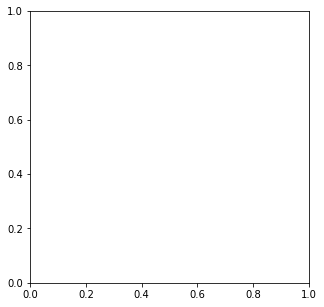

In [ ]:
plot_loss(history.history)